In [121]:
import torch
from torch.autograd.functional import hessian
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, least_squares

from aeons.covariance import X_mu, X_Sigmainv
from aeons.true_distribution import generate_Xs, nk_dead, nk_dead_live, nk_live
from aeons.likelihoods import linear, quad, simple, middle, full
from models import LS, CG

In [122]:
def linear_noisy(x, m, sigma):
    noise = np.random.normal(0, sigma, len(x))
    return m * x + noise

def quad_noisy(x, m, sigma):
    noise = np.random.normal(0, sigma, len(x))
    return m * x**2 + noise

def minimise_m(y, x, m0):
    def func(m):
        return y - linear.func(x, m)
    return least_squares(func, m0)

def logPr_m(y, x, m, sigma):
    N = len(y)
    loss = y - linear.func(x, m)
    L_sq = np.sum(loss**2)
    return -0.5 * N * np.log(2*np.pi*sigma**2) - L_sq/(2*sigma**2)

def hess_m(y, x, m_max, sigma):
    N = len(y)
    y = torch.from_numpy(y)
    x = torch.from_numpy(x)
    theta_max = torch.tensor([*m_max, sigma], requires_grad=True)
    def func(theta):
        m, sigma = theta
        loss = y - linear.func(x, m)
        L_sq = torch.sum(loss**2)
        return -0.5 * N * torch.log(2*np.pi*sigma**2) - L_sq/(2*sigma**2)
    H = hessian(func, theta_max)
    return np.array(H)

def logZ(logPmax, H, D):
    return logPmax - 1/2 * np.log(abs(np.linalg.det(H))) + D/2 * np.log(2*np.pi)

def avg_evidence(y, x, m_true, sigma, repeats=5):
    evidences = []
    for i in range(repeats):
        y = linear_noisy(x, m_true, sigma)
        m = minimise_m(y, x, 10).x
        logPr_max_m = logPr_m(y, x, m, sigma)
        H = hess_m(y, x, m, sigma)
        evidence = logZ(logPr_max_m, H, D=2)
        evidences.append(evidence)
    return np.mean(evidences)

### **Toy model**

NS models fall on a sliding scale between two cases:

**(1)** Low noise + good model:
- More points = more evidence
- Good model means cost always small, evidence is dominated by increase in $\sigma$, N term

**(2)** High noise OR poor model:
- More points = less evidence
- Cost blows up for more N because of bad fit, evidence dominated by this rather than $\sigma$, N term



If data is noisy - use more points. *Bandwidth should try to tackle cases where model is bad for some dead points, but good for the live points*

Always want the model to be good for the live points. What if this isn't the case?

##### High vs low noise

In [4]:
m_true = 10
sigma = 0.1

x = np.linspace(0, 10, 10)
y = linear_noisy(x, m_true, sigma)

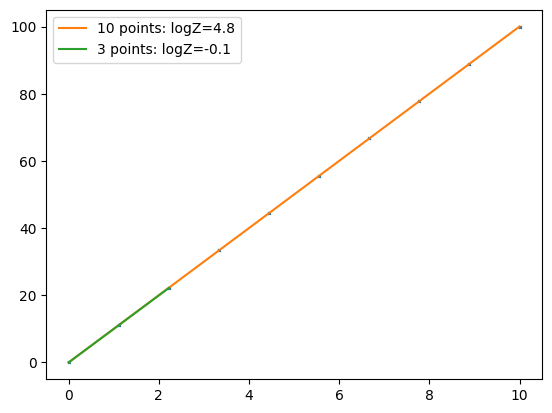

In [6]:
end = 3
xf = x[:end]
yf = y[:end]
mf = minimise_m(yf, xf, 10).x
m = minimise_m(y, x, 10).x
logPr_max_m = logPr_m(y, x, m, sigma)
H = hess_m(y, x, m, sigma)
evidence = logZ(logPr_max_m, H, D=2)

logPr_max_mf = logPr_m(yf, xf, mf, sigma)
Hf = hess_m(yf, xf, mf, sigma)
evidence_f = logZ(logPr_max_mf, Hf, D=2)

plt.plot(x, y, 'x', ms=2);
plt.plot(x, linear.func(x, m), label=f'10 points: logZ={evidence:.1f}');
plt.plot(xf, linear.func(xf, mf), label=f'3 points: logZ={evidence_f:.1f}');
plt.legend();

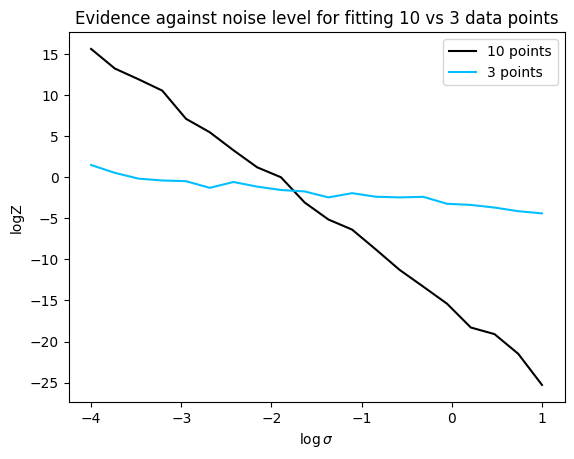

In [10]:
noise_level = np.exp(np.linspace(-4, 1, 20))
evidence_full = np.zeros_like(noise_level)
evidence_partial = np.zeros_like(noise_level)
for i, sigma in enumerate(noise_level):
    y = linear_noisy(x, m_true, sigma)
    yf = y[:end]
    evidence_full[i] = avg_evidence(y, x, m_true, sigma, repeats=20)
    evidence_partial[i] = avg_evidence(yf, xf, m_true, sigma, repeats=20)
plt.plot(np.log(noise_level), evidence_full, color='black', label='10 points')
plt.plot(np.log(noise_level), evidence_partial, color='deepskyblue', label='3 points');
plt.xlabel(r"$\log \sigma$")
plt.ylabel("logZ");
plt.legend();
plt.title("Evidence against noise level for fitting 10 vs 3 data points");

##### Low noise, bad model

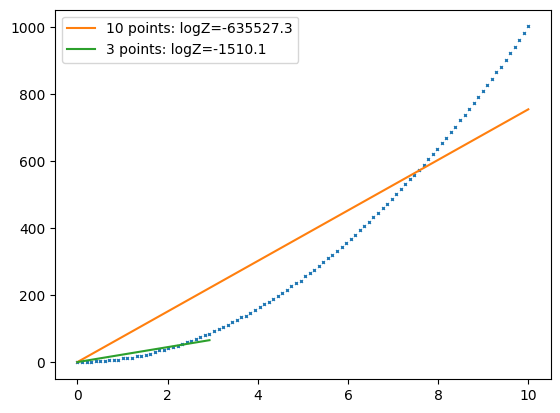

In [130]:
m_true = 10
sigma = 1

x = np.linspace(0, 10, 100)
y = quad_noisy(x, m_true, sigma)

end = 30
xf = x[:end]
yf = y[:end]
mf = minimise_m(yf, xf, 10).x
m = minimise_m(y, x, 10).x
logPr_max_m = logPr_m(y, x, m, sigma)
H = hess_m(y, x, m, sigma)
evidence = logZ(logPr_max_m, H, D=2)

logPr_max_mf = logPr_m(yf, xf, mf, sigma)
Hf = hess_m(yf, xf, mf, sigma)
evidence_f = logZ(logPr_max_mf, Hf, D=2)

plt.plot(x, y, 'x', ms=2);
plt.plot(x, linear.func(x, m), label=f'10 points: logZ={evidence:.1f}');
plt.plot(xf, linear.func(xf, mf), label=f'3 points: logZ={evidence_f:.1f}');
plt.legend();

### **Gaussian - good model, low noise**
Few things:
- logL plotted against mean, because this is what least squares thinks it's trying to fit - see how successful it is at its goal

- Model is still a good fit to data for large number of points. More evidence for more data **before** introducing penalty for fewer points
- Suggests we should use all of the data. If we introduce the evidence penalty for using few points, we would get the same conclusion.

In [98]:
nk = nk_dead_live(nlive=500, ndead=500)
mean = X_mu(nk)
covinv = X_Sigmainv(nk)

In [105]:
X = generate_Xs(nk)
theta_true = 10
like = simple
y = like.func(X, theta_true)
ls = LS(y, like, mean)

startf = 300
Nf = 400
Xf = X[startf:startf+Nf]
yf = y[startf:startf+Nf]
meanf = mean[startf:startf+Nf]
lsf = LS(yf, like, meanf)

logPr_max: 3950.501471953118, Hessian: -14.412406052723616
logPr_max: 1687.9088239729185, Hessian: -14.235941240437512


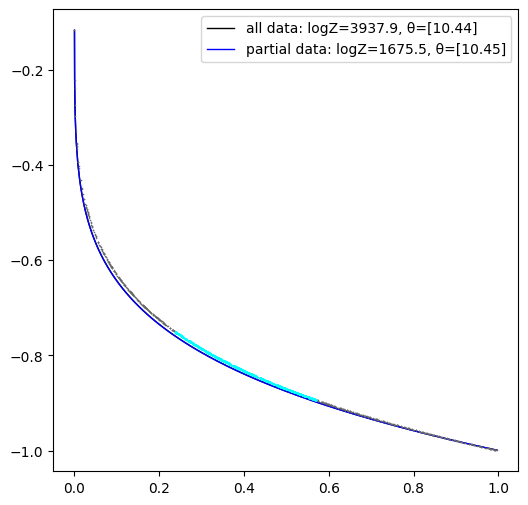

In [106]:
theta_l = ls.minimise(theta_true)
theta_lf = lsf.minimise(theta_true)
logZ_l = ls.logZ(theta_l, details=True)
logZ_lf = lsf.logZ(theta_lf, details=True)
plt.figure(figsize=(6,6))
plt.plot(like.inverse(y, theta_l), y, label=f'all data: logZ={logZ_l:.1f}, θ={np.round(theta_l, 2)}', lw=1, color='black')
plt.plot(like.inverse(y, theta_lf), y, label=f'partial data: logZ={logZ_lf:.1f}, θ={np.round(theta_lf, 2)}', lw=1, color='blue')
# plt.plot(mean, y, 'x', ms=.5, color='dimgray')
# plt.plot(meanf, yf, 'x', ms=1, color='cyan')
plt.plot(X, y, 'x', ms=.5, color='dimgray')
plt.plot(Xf, yf, 'x', ms=1, color='cyan')
plt.legend();

### **Cauchy - okay model, low noise**

Model still good enough that using more data gathers more evidence

In [131]:
def cauchy(X, theta=.1):
    return np.log(theta/(theta**2 + X**2))
nk = nk_dead_live(500, 500)
mean = X_mu(nk)
covinv = X_Sigmainv(nk)

In [132]:
X = generate_Xs(nk)
y = cauchy(X, 0.1)
like = full
ls = LS(y, like, mean)

startf = 300
Nf = 500
Xf = X[startf:startf+Nf]
yf = y[startf:startf+Nf]
meanf = mean[startf:startf+Nf]
lsf = LS(yf, like, meanf)

logPr_max: 2815.114482972865, Hessian: -23.7615241546781
logPr_max: 2030.4047871076427, Hessian: -25.967299240762856


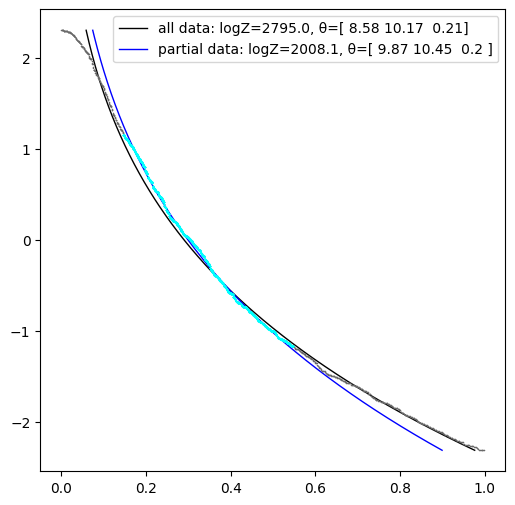

In [136]:
theta_l = ls.minimise([6, 6, 0.1])
theta_lf = lsf.minimise([5, 10, 0.1])
logZ_l = ls.logZ(theta_l, details=True)
logZ_lf = lsf.logZ(theta_lf, details=True)
plt.figure(figsize=(6,6))
plt.plot(like.inverse(y, theta_l), y, label=f'all data: logZ={logZ_l:.1f}, θ={np.round(theta_l, 2)}', lw=1, color='black')
plt.plot(like.inverse(y, theta_lf), y, label=f'partial data: logZ={logZ_lf:.1f}, θ={np.round(theta_lf, 2)}', lw=1, color='blue')
plt.plot(mean, y, 'x', ms=.5, color='dimgray')
plt.plot(meanf, yf, 'x', ms=1, color='cyan')
# plt.plot(X, y, 'x', ms=.5, color='dimgray')
# plt.plot(Xf, yf, 'x', ms=1, color='cyan')
plt.legend();

### **Wedding cake - bad model and high noise**

Evidences more like case (2), even more so compared to Cauchy. What do we actually want to achieve with the bandwidth?

In [195]:
def simple_step(X, theta, steps=10):
    X = np.floor(X * steps)/steps
    return -X**(2/theta)
nlive, ndead = 500, 500
nk = nk_dead_live(nlive, ndead)
mean = X_mu(nk)
# covinv = X_Sigmainv(nk)

In [205]:
X = generate_Xs(nk)
y = simple_step(X, 10, steps=5)
like = full
ls = LS(y, like, mean)

alpha = 0.8
startf = int(ndead * (1 - alpha))
Xf = X[startf:]
yf = y[startf:]
meanf = mean[startf:]
lsf = LS(yf, like, meanf)

logPr_max: 1109.406211137172, Hessian: -18.088674330205386
logPr_max: 999.3124282789865, Hessian: -18.297698596213586


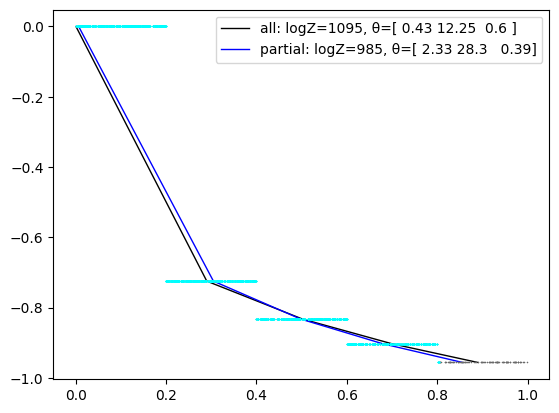

In [211]:
theta_l = ls.minimise([6, 6, 0.1])
theta_lf = lsf.minimise([1, 10, 0.1])
logZ_l = ls.logZ(theta_l, details=True)
logZ_lf = lsf.logZ(theta_lf, details=True)
# plt.figure(figsize=(6,6))
plt.plot(like.inverse(y, theta_l), y, label=f'all: logZ={logZ_l:.0f}, θ={np.round(theta_l, 2)}', lw=1, color='black')
plt.plot(like.inverse(y, theta_lf), y, label=f'partial: logZ={logZ_lf:.0f}, θ={np.round(theta_lf, 2)}', lw=1, color='blue')
# plt.plot(mean, y, 'x', ms=.5, color='dimgray')
# plt.plot(meanf, yf, 'x', ms=1, color='cyan')
plt.plot(X, y, 'x', ms=.5, color='dimgray')
plt.plot(Xf, yf, 'x', ms=1, color='cyan')
plt.legend();